In [ ]:
import pandas as pd
import numpy as np

import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

import joblib

In [ ]:
# Download latest version of dataset
dataset_path = kagglehub.dataset_download(
    "nikitamanaenkov/satisfaction-and-environmental-qual-in-classrooms"
)

print("Dataset downloaded at:", dataset_path)

Using Colab cache for faster access to the 'satisfaction-and-environmental-qual-in-classrooms' dataset.
Dataset downloaded at: /kaggle/input/satisfaction-and-environmental-qual-in-classrooms


In [ ]:
import os

for root, dirs, files in os.walk(dataset_path):
    print("📂", root)
    for file in files:
        print("   └──", file)

📂 /kaggle/input/satisfaction-and-environmental-qual-in-classrooms
📂 /kaggle/input/satisfaction-and-environmental-qual-in-classrooms/data
   └── FullDataset_TestLectureRoom.csv
   └── OccupantSurveys.pdf
   └── FullDataset_SecondarySchool.csv
   └── FullDataset_CombinedSimple.csv
   └── Dataset_ParameterDescription.xlsx
   └── FullDataset_PrimarySchools.csv


In [ ]:
csv_path = None

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".csv"):
            csv_path = os.path.join(root, file)
            break
    if csv_path:
        break

if csv_path is None:
    raise FileNotFoundError("No CSV file found in dataset directory.")

print("Using CSV file:", csv_path)

Using CSV file: /kaggle/input/satisfaction-and-environmental-qual-in-classrooms/data/FullDataset_TestLectureRoom.csv


In [ ]:
csv_path = os.path.join(
    dataset_path,
    "data",
    "FullDataset_SecondarySchool.csv"
)

print("Using CSV file:", csv_path)


Using CSV file: /kaggle/input/satisfaction-and-environmental-qual-in-classrooms/data/FullDataset_SecondarySchool.csv


In [ ]:
df = pd.read_csv(csv_path)

print("Dataset shape:", df.shape)
df.head()
print("\nColumn names:")
print(df.columns)

Dataset shape: (834, 86)

Column names:
Index(['TimeVote', 'Classroom', 'ID', 'Moment', 'Student', 'Clothing',
       'Activity', 'ActivityOther', 'WindowOpening', 'ThermalSatisfaction',
       'IAQSatisfaction', 'AcousticSatisfaction', 'VisualSatisfaction',
       'DissatisfactionThermal', 'DissatisfactionThermalOther',
       'DissatisfactionIAQ', 'DissatisfactionIAQOther',
       'DissatisfactionAcoustic', 'DissatisfactionAcousticOther',
       'DissatisfactionVisual', 'DissatisfactionVisualOther',
       'IEQSatisfaction', 'IEQRemarks', 'Trm', 'VOC_Back', 'CO2_Back',
       'LightLux_Back', 'RH_Back', 'SoundLevel_Back', 'SoundMax_Back',
       'SoundMin_Back', 'Temp_Back', 'Time_Back', 'VOC_Middle', 'CO2_Middle',
       'LightLux_Middle', 'RH_Middle', 'SoundLevel_Middle', 'SoundMax_Middle',
       'SoundMin_Middle', 'Temp_Middle', 'EA_Middle', 'Trend_T_Middle',
       'Time_Middle', 'VOC_Front', 'CO2_Front', 'LightLux_Front', 'RH_Front',
       'SoundLevel_Front', 'SoundMax_Front',

In [ ]:
# Data types
print("\nData types:")
print(df.dtypes.value_counts())

# Missing values
print("\nMissing values (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))


Data types:
bool       30
object     26
float64    22
int64       8
Name: count, dtype: int64

Missing values (top 10):
DissatisfactionIAQOther         833
DissatisfactionVisualOther      833
DissatisfactionAcousticOther    832
DissatisfactionThermalOther     830
DissatisfactionVisual           798
ActivityOther                   797
DissatisfactionAcoustic         792
IEQRemarks                      771
DissatisfactionIAQ              670
DissatisfactionThermal          652
dtype: int64


In [ ]:
print(df.columns.tolist())

['TimeVote', 'Classroom', 'ID', 'Moment', 'Student', 'Clothing', 'Activity', 'ActivityOther', 'WindowOpening', 'ThermalSatisfaction', 'IAQSatisfaction', 'AcousticSatisfaction', 'VisualSatisfaction', 'DissatisfactionThermal', 'DissatisfactionThermalOther', 'DissatisfactionIAQ', 'DissatisfactionIAQOther', 'DissatisfactionAcoustic', 'DissatisfactionAcousticOther', 'DissatisfactionVisual', 'DissatisfactionVisualOther', 'IEQSatisfaction', 'IEQRemarks', 'Trm', 'VOC_Back', 'CO2_Back', 'LightLux_Back', 'RH_Back', 'SoundLevel_Back', 'SoundMax_Back', 'SoundMin_Back', 'Temp_Back', 'Time_Back', 'VOC_Middle', 'CO2_Middle', 'LightLux_Middle', 'RH_Middle', 'SoundLevel_Middle', 'SoundMax_Middle', 'SoundMin_Middle', 'Temp_Middle', 'EA_Middle', 'Trend_T_Middle', 'Time_Middle', 'VOC_Front', 'CO2_Front', 'LightLux_Front', 'RH_Front', 'SoundLevel_Front', 'SoundMax_Front', 'SoundMin_Front', 'Temp_Front', 'Time_Front', 'Location_V', 'Location_H', 'LocationBack', 'LocationFront', 'LocationBlackboard', 'Locati

In [ ]:
TARGET_COLUMN = "IEQSatisfaction"

# Drop rows with missing target
df = df.dropna(subset=[TARGET_COLUMN])

# Binary target
df["target"] = df[TARGET_COLUMN].apply(lambda x: 1 if x >= 4 else 0)

df["target"].value_counts(normalize=True) * 100

,proportion
target,
0,60.911271
1,39.088729


In [ ]:
X = df.drop(columns=[TARGET_COLUMN, "target"])
y = df["target"]

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

Feature shape: (834, 85)
Target shape: (834,)


In [ ]:
X = X.select_dtypes(include=["number"])

print("Numeric feature count:", X.shape[1])

Numeric feature count: 29


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (667, 29)
Test size: (167, 29)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled training shape:", X_train_scaled.shape)
print("Scaled test shape:", X_test_scaled.shape)

Scaled training shape: (667, 29)
Scaled test shape: (167, 29)


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    )
}

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)


In [ ]:
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "MCC": matthews_corrcoef(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
results_df

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:07:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,AUC,Precision,Recall,F1,MCC
0,Logistic Regression,0.844311,0.944495,0.782609,0.830769,0.805970,0.677004
1,Decision Tree,0.784431,0.784389,0.704225,0.769231,0.735294,0.555609
2,KNN,0.832335,0.892760,0.776119,0.800000,0.787879,0.649521
3,Naive Bayes,0.856287,0.924434,0.805970,0.830769,0.818182,0.699635
4,Random Forest,0.844311,0.938612,0.782609,0.830769,0.805970,0.677004
5,XGBoost,0.856287,0.938914,0.788732,0.861538,0.823529,0.704664


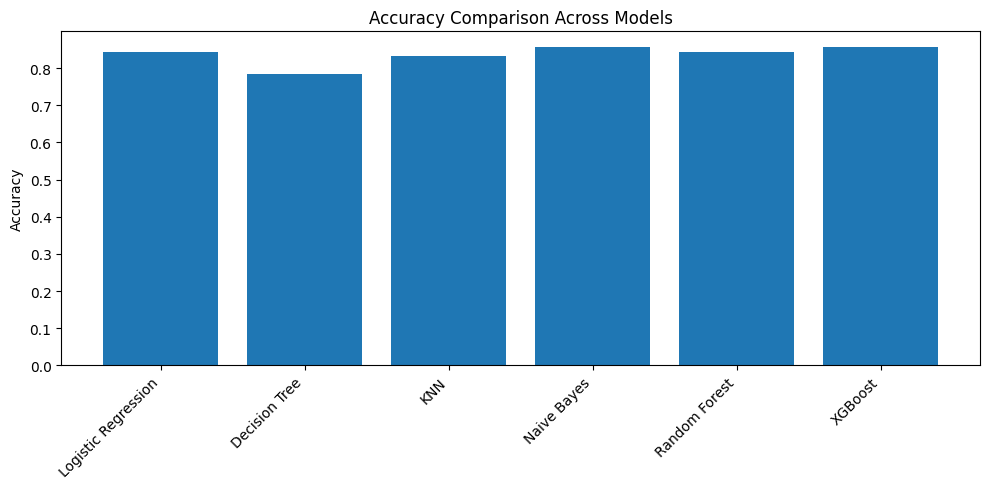

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(results_df["Model"], results_df["Accuracy"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Models")
plt.tight_layout()
plt.show()

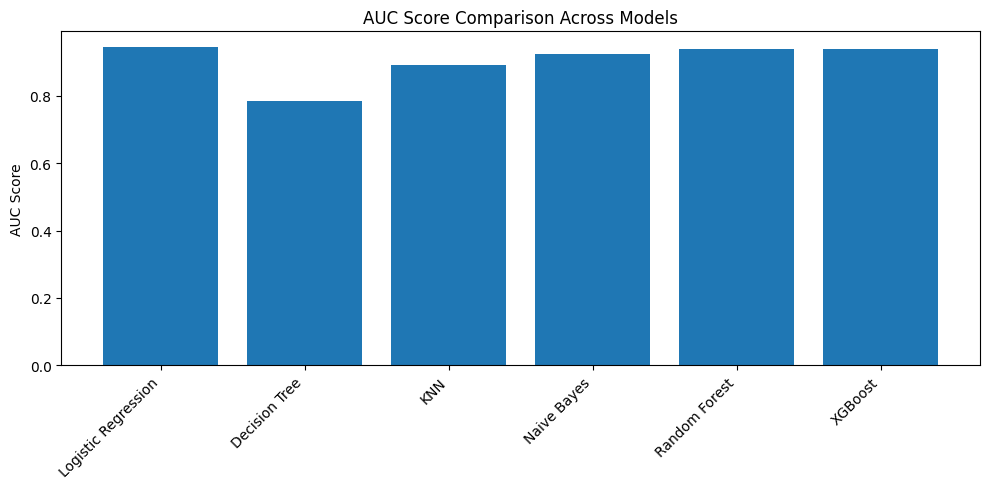

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(results_df["Model"], results_df["AUC"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("AUC Score")
plt.title("AUC Score Comparison Across Models")
plt.tight_layout()
plt.show()

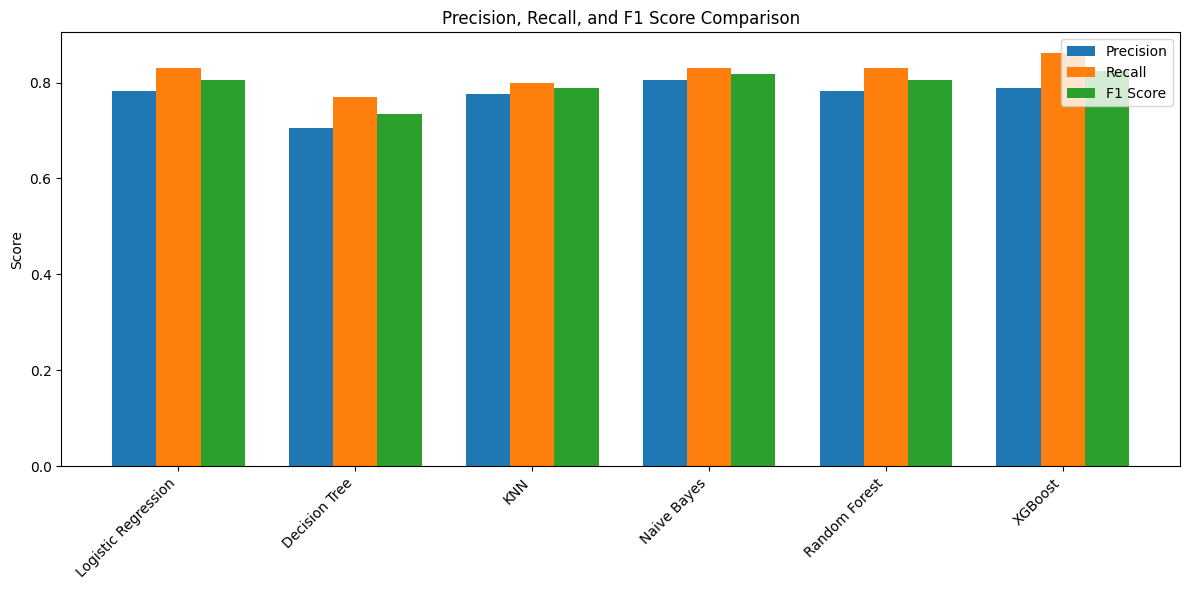

In [ ]:
x = np.arange(len(results_df))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, results_df["Precision"], width, label="Precision")
plt.bar(x, results_df["Recall"], width, label="Recall")
plt.bar(x + width, results_df["F1"], width, label="F1 Score")

plt.xticks(x, results_df["Model"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score Comparison")
plt.legend()
plt.tight_layout()
plt.show()

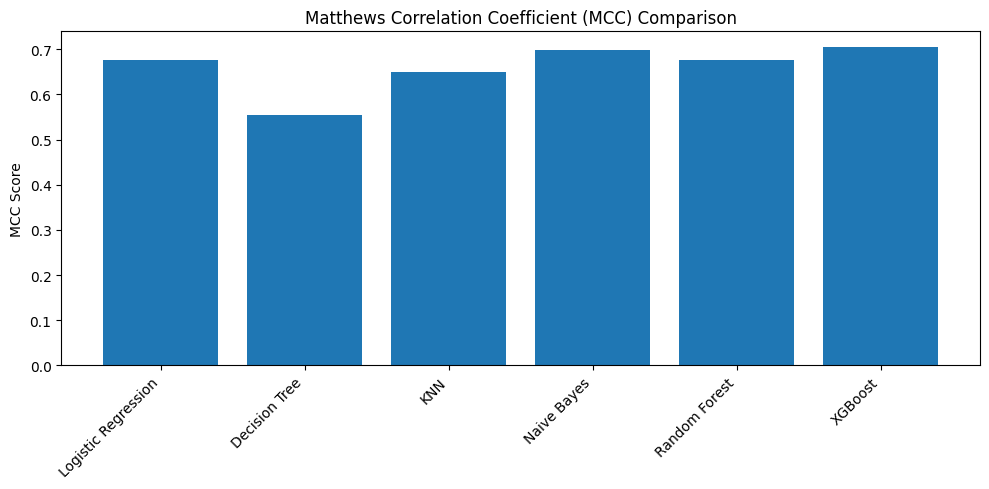

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(results_df["Model"], results_df["MCC"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("MCC Score")
plt.title("Matthews Correlation Coefficient (MCC) Comparison")
plt.tight_layout()
plt.show()

In [ ]:
feature_means = X_train.mean()

joblib.dump(
    {
        "models": models,
        "scaler": scaler,
        "feature_means": feature_means,
        "metrics": results_df
    },
    "ieq_models.joblib"
)

print("ieq_models.joblib saved")

ieq_models.joblib saved


In [ ]:
good_samples = X_test[y_test == 1].head(10)

print("Satisfied samples selected:", good_samples.shape[0])
good_samples.head()

Satisfied samples selected: 10


,ThermalSatisfaction,IAQSatisfaction,AcousticSatisfaction,VisualSatisfaction,Trm,CO2_Back,LightLux_Back,RH_Back,SoundLevel_Back,SoundMax_Back,...,EA_Middle,Trend_T_Middle,CO2_Front,LightLux_Front,RH_Front,SoundLevel_Front,SoundMax_Front,SoundMin_Front,Temp_Front,Age
213,4,4,4,4,10.9,709,224.074,32.278,62.307,72.285,...,37.377,1.508,923,54.582,33.076,66.884,71.246,46.535,22.447,15.0
69,4,4,4,4,12.6,810,387.517,32.778,64.181,75.815,...,40.028,0.270,1080,619.901,35.152,55.333,69.566,37.397,23.382,15.0
283,4,4,4,4,13.8,589,326.604,52.925,75.919,89.577,...,42.918,0.863,959,522.863,49.346,66.781,84.144,52.178,22.743,16.0
507,3,3,5,4,12.6,1005,309.422,36.108,51.213,83.469,...,37.176,0.240,569,24.872,34.782,71.231,78.789,45.768,21.705,15.0
480,3,4,5,4,22.6,548,23.020,50.845,62.115,79.518,...,48.826,-0.238,834,186.681,50.120,50.647,76.868,42.325,24.613,15.0


In [ ]:
# Select 10 satisfied samples from test set
good_samples = X_test[y_test == 1].head(10)

print("Satisfied samples selected:", good_samples.shape[0])
good_samples.head()

Satisfied samples selected: 10


,ThermalSatisfaction,IAQSatisfaction,AcousticSatisfaction,VisualSatisfaction,Trm,CO2_Back,LightLux_Back,RH_Back,SoundLevel_Back,SoundMax_Back,...,EA_Middle,Trend_T_Middle,CO2_Front,LightLux_Front,RH_Front,SoundLevel_Front,SoundMax_Front,SoundMin_Front,Temp_Front,Age
213,4,4,4,4,10.9,709,224.074,32.278,62.307,72.285,...,37.377,1.508,923,54.582,33.076,66.884,71.246,46.535,22.447,15.0
69,4,4,4,4,12.6,810,387.517,32.778,64.181,75.815,...,40.028,0.270,1080,619.901,35.152,55.333,69.566,37.397,23.382,15.0
283,4,4,4,4,13.8,589,326.604,52.925,75.919,89.577,...,42.918,0.863,959,522.863,49.346,66.781,84.144,52.178,22.743,16.0
507,3,3,5,4,12.6,1005,309.422,36.108,51.213,83.469,...,37.176,0.240,569,24.872,34.782,71.231,78.789,45.768,21.705,15.0
480,3,4,5,4,22.6,548,23.020,50.845,62.115,79.518,...,48.826,-0.238,834,186.681,50.120,50.647,76.868,42.325,24.613,15.0


In [ ]:
# Apply SAME preprocessing as training
good_samples_imputed = imputer.transform(good_samples)
good_samples_scaled = scaler.transform(good_samples_imputed)

In [ ]:
comparison_results = []

for model_name, model in models.items():
    probs = model.predict_proba(good_samples_scaled)[:, 1]

    comparison_results.append({
        "Model": model_name,
        "Average Probability (%)": round(probs.mean() * 100, 2),
        "Min Probability (%)": round(probs.min() * 100, 2),
        "Max Probability (%)": round(probs.max() * 100, 2)
    })

comparison_df = pd.DataFrame(comparison_results)
comparison_df

,Model,Average Probability (%),Min Probability (%),Max Probability (%)
0,Logistic Regression,71.83,26.35,93.930000
1,Decision Tree,75.00,0.00,100.000000
2,KNN,62.00,40.00,100.000000
3,Naive Bayes,77.51,26.85,99.930000
4,Random Forest,73.40,41.50,99.500000
5,XGBoost,76.25,8.74,99.989998


In [ ]:
detailed_df = pd.DataFrame(index=good_samples.index)

for model_name, model in models.items():
    detailed_df[f"{model_name}_Prob(%)"] = (
        model.predict_proba(good_samples_scaled)[:, 1] * 100
    ).round(2)

detailed_df

,Logistic Regression_Prob(%),Decision Tree_Prob(%),KNN_Prob(%),Naive Bayes_Prob(%),Random Forest_Prob(%),XGBoost_Prob(%)
213,88.11,100.0,100.0,99.12,99.50,99.860001
69,91.73,100.0,40.0,96.81,79.00,97.860001
283,93.93,100.0,60.0,99.93,99.50,99.709999
507,26.35,100.0,60.0,55.30,61.50,75.019997
480,72.54,0.0,60.0,52.77,41.50,8.740000
666,43.19,100.0,60.0,26.85,64.50,72.550003
645,82.84,50.0,60.0,69.82,59.00,96.610001
244,85.89,100.0,100.0,92.98,99.50,99.989998
350,83.05,100.0,40.0,93.93,84.50,99.070000
247,50.71,0.0,40.0,87.64,45.53,13.070000


In [ ]:
good_samples.to_csv("ieq_satisfied_test_samples.csv", index=False)
print("ieq_satisfied_test_samples.csv saved")

ieq_satisfied_test_samples.csv saved


In [ ]:
# Create an example row using feature means
example_row = X_train.mean().to_frame().T

# Round for readability
example_row = example_row.round(3)

# Save template CSV
example_row.to_csv("ieq_full_feature_template.csv", index=False)

example_row.head()


,ThermalSatisfaction,IAQSatisfaction,AcousticSatisfaction,VisualSatisfaction,Trm,CO2_Back,LightLux_Back,RH_Back,SoundLevel_Back,SoundMax_Back,...,EA_Middle,Trend_T_Middle,CO2_Front,LightLux_Front,RH_Front,SoundLevel_Front,SoundMax_Front,SoundMin_Front,Temp_Front,Age
0,3.187,3.147,3.675,3.759,14.803,612.949,325.241,35.776,62.763,77.925,...,40.658,0.358,723.889,280.182,36.1,55.733,68.711,38.967,23.085,15.812


In [ ]:
# Take first 5 rows from test set
test_samples = X_test.iloc[:5].copy()

# Save test samples
test_samples.to_csv("ieq_test_samples.csv", index=False)

test_samples.head()


,ThermalSatisfaction,IAQSatisfaction,AcousticSatisfaction,VisualSatisfaction,Trm,CO2_Back,LightLux_Back,RH_Back,SoundLevel_Back,SoundMax_Back,...,EA_Middle,Trend_T_Middle,CO2_Front,LightLux_Front,RH_Front,SoundLevel_Front,SoundMax_Front,SoundMin_Front,Temp_Front,Age
634,3,3,3,3,13.6,573,722.642,41.574,67.015,76.059,...,45.066,1.418,1005,372.518,44.550,57.116,73.796,48.161,22.863,16.0
528,3,2,4,4,12.6,903,352.026,32.129,67.434,90.255,...,40.698,1.017,1074,524.342,34.347,57.585,74.696,40.019,23.120,NaN
213,4,4,4,4,10.9,709,224.074,32.278,62.307,72.285,...,37.377,1.508,923,54.582,33.076,66.884,71.246,46.535,22.447,15.0
69,4,4,4,4,12.6,810,387.517,32.778,64.181,75.815,...,40.028,0.270,1080,619.901,35.152,55.333,69.566,37.397,23.382,15.0
283,4,4,4,4,13.8,589,326.604,52.925,75.919,89.577,...,42.918,0.863,959,522.863,49.346,66.781,84.144,52.178,22.743,16.0


In [ ]:
# Notebook prediction for verification (ALL models) — FIXED

verification_results = {}

# Apply SAME preprocessing as training
test_samples_imputed = imputer.transform(test_samples)
test_samples_scaled = scaler.transform(test_samples_imputed)

for model_name, model in models.items():
    probs = model.predict_proba(test_samples_scaled)[:, 1]
    verification_results[model_name] = (probs * 100).round(2)

verification_df = pd.DataFrame(verification_results)
verification_df

,Logistic Regression,Decision Tree,KNN,Naive Bayes,Random Forest,XGBoost
0,9.38,0.0,40.0,10.70,5.25,0.060000
1,5.09,100.0,60.0,10.41,28.67,0.560000
2,88.11,100.0,100.0,99.12,99.50,99.860001
3,91.73,100.0,40.0,96.81,79.00,97.860001
4,93.93,100.0,60.0,99.93,99.50,99.709999


In [ ]:
label_df = verification_df.applymap(
    lambda x: "Satisfied" if x >= 50 else "Not Satisfied"
)

label_df

/tmp/ipython-input-3424290558.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  label_df = verification_df.applymap(


,Logistic Regression,Decision Tree,KNN,Naive Bayes,Random Forest,XGBoost
0,Not Satisfied,Not Satisfied,Not Satisfied,Not Satisfied,Not Satisfied,Not Satisfied
1,Not Satisfied,Satisfied,Satisfied,Not Satisfied,Not Satisfied,Not Satisfied
2,Satisfied,Satisfied,Satisfied,Satisfied,Satisfied,Satisfied
3,Satisfied,Satisfied,Not Satisfied,Satisfied,Satisfied,Satisfied
4,Satisfied,Satisfied,Satisfied,Satisfied,Satisfied,Satisfied
